# Dispensers by Status Last 24Hrs. TEST

Verify the pie chart data is correct. Compare with postgres data.


In [65]:
from datetime import datetime, timezone, timedelta
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import os
import pandas as pd
from sqlalchemy import create_engine

## Environment variables

Load environment variables and create url postgres conection

In [66]:
load_dotenv(".env")
user = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST")
port = os.getenv("POSTGRES_PORT")
database = os.getenv("POSTGRES_DB")

url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(url)


## Get database info

In [67]:
debug = True

Get current UTC time and subtract 24 hours

In [68]:
utc_now = datetime.now(timezone.utc)
utc_24h_before = utc_now - timedelta(hours=24)

Data input

In [69]:
organization_name = "BBB Industries"
start_date = utc_24h_before.strftime('%Y-%m-%d %H:%M:%S')
end_date = utc_now.strftime('%Y-%m-%d %H:%M:%S')

In [70]:
if debug:
    print("start date:", start_date)
    print("end date:", end_date)

start date: 2025-05-28 00:16:22
end date: 2025-05-29 00:16:22


Get all rid units of the organization

In [71]:
query = "SELECT U.rid as rid "\
"FROM units.unit AS U "\
"LEFT JOIN \"authorization\".organization AS O "\
"ON U.id_organization = O.id "\
"WHERE O.name = '" + f"{organization_name}'"

if(debug):print(query)

SELECT U.rid as rid FROM units.unit AS U LEFT JOIN "authorization".organization AS O ON U.id_organization = O.id WHERE O.name = 'BBB Industries'


In [72]:
df = pd.read_sql_query(query, con=engine)
df

,rid
0,RD201140
1,RD201141


Convert the result to a list to have into the format: ['RD01','RD02'] and check if array is empty

In [73]:
array = df['rid'].to_numpy().tolist()
if(debug):print(array)
if len(array) == 0:
    array_string = "NULL"
else:
    array_string = "ARRAY" + f"{array} "

['RD201140', 'RD201141']


For each unit, we obtain its status with its own percentage.

In [74]:
query="SELECT status,sum(percentage) AS Percentage "\
"FROM get_percentage_duration("+f"'{start_date}',"+f"'{end_date}',"\
+ array_string +",NULL) "\
"GROUP BY status"

if(debug):print(query)

SELECT status,sum(percentage) AS Percentage FROM get_percentage_duration('2025-05-28 00:16:22','2025-05-29 00:16:22',ARRAY['RD201140', 'RD201141'] ,NULL) GROUP BY status


In [75]:
df = pd.read_sql_query(query, con=engine)
df

,status,percentage
0,plugged in,0.354
1,charging,199.646


We calculate the total percentage of status by organization.

In [76]:
sumPercentage = df["percentage"].sum()
df["totalPercentage"] = round(((df["percentage"]* 100) / sumPercentage),3)

In [77]:
df1 = df.iloc[:,[0,2]]
df1

,status,totalPercentage
0,plugged in,0.177
1,charging,99.823


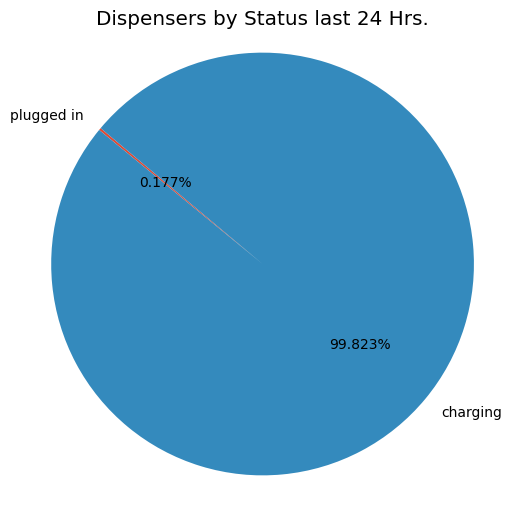

In [78]:
# Pie chart
plt.style.use('ggplot')
plt.figure(figsize=(6, 6))
plt.pie(df1['totalPercentage'], labels=df1['status'], autopct='%1.3f%%', startangle=140)
plt.title('Dispensers by Status last 24 Hrs.')
plt.axis('equal')  # To be a circle
plt.show()

## Compare results

In [81]:
expectedFaulted = 0
expectedUnavailable = 0
expectedDisabled = 0
expectedEpo = 0
expectedPluggedIn = 3.244
expectedAvailable = 40.67
expectedDischarging = 0
expectedCharging = 56.086
df2 = pd.DataFrame(
    {
    "status": ['faulted','unavailable','disabled','epo','plugged in', 'available','discharging', 'charging'],
    "totalPercentage": [expectedFaulted,expectedUnavailable,expectedDisabled,expectedEpo,expectedPluggedIn, expectedAvailable, expectedDischarging, expectedCharging],
    }
)

# df2 = pd.DataFrame(
#     {
#     "status": ['plugged in', 'available','charging'],
#     "totalPercentage": [expectedPluggedIn, expectedAvailable, expectedCharging],
#     }
# )
df2



,status,totalPercentage
0,faulted,0.000
1,unavailable,0.000
2,disabled,0.000
3,epo,0.000
4,plugged in,3.244
5,available,40.670
6,discharging,0.000
7,charging,56.086


In [82]:
import pandas.testing as pdt
try:
    pdt.assert_frame_equal(df1, df2)
    print("SUCCESS: Data is the same.")
except AssertionError as e:
    print("FAIL: Data is different.")
    print(e)

FAIL: Data is different.
DataFrame are different

DataFrame shape mismatch
[left]:  (2, 2)
[right]: (8, 2)
